# set up

### libraries

In [1]:
#@title import packages

import albumentations as A
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torchvision
import skimage

from glob import glob
from lsd.train import local_shape_descriptor
from scipy.ndimage import binary_erosion
from skimage.measure import label
from skimage.io import imread
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.auto import tqdm

import torchvision.transforms as T


import pandas as pd

import warnings
warnings.filterwarnings("ignore")

/localscratch/conda/envs/lsd-env/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### stuff that is needed

In [2]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True

### affinities code

(from gunpowder package)

### dataset creation

In [ ]:
class CellDataset(Dataset):
    def __init__(
        self,
        image_dir,
        mask_dir,
        crop_size=None,
        padding_size=8,
        input_type = 'raw',
        output_type = 'labels',
        split = 'train',
        model = None):

        self.images = sorted(glob(image_dir))
        self.masks = sorted(glob(mask_dir))

        self.crop_size = crop_size
        self.padding_size = padding_size

        self.input_type = input_type
        self.output_type = output_type

        self.split = split

        # model to use predictions as input
        self.model = model


    def __len__(self):
        return len(self.images)

    # function to erode label boundaries
    def erode(self, labels, iterations, border_value):

        foreground = np.zeros_like(labels, dtype=bool)

        # loop through unique labels
        for label in np.unique(labels):

            # skip background
            if label == 0:
                continue

            # mask to label
            label_mask = labels == label

            # erode labels
            eroded_mask = binary_erosion(
                    label_mask,
                    iterations=iterations,
                    border_value=border_value)

            # get foreground
            foreground = np.logical_or(eroded_mask, foreground)

        # and background...
        background = np.logical_not(foreground)

        # set eroded pixels to zero
        labels[background] = 0

        return labels

    def get_lsds(self, labels):
        labels = self.erode(
            labels,
            iterations=1,
            border_value=1)
        
        lsds = local_shape_descriptor.get_local_shape_descriptors(
                segmentation=labels,
                sigma=(10,)*2,
                voxel_size=(1,)*2)
        
        return lsds.astype(np.float32)

    def get_aff(self, seg):

        nhood=[
            [0, -1],
            [-1, 0]]

        nhood = np.array(nhood)

        # constructs an affinity graph from a segmentation
        # assume affinity graph is represented as:
        # shape = (e, z, y, x)
        # nhood.shape = (edges, 3)
        shape = seg.shape
        nEdge = nhood.shape[0]
        dims = nhood.shape[1]
        aff = np.zeros((nEdge,) + shape, dtype=np.int32)

        if dims == 2:

            for e in range(nEdge):
                aff[e, \
                    max(0,-nhood[e,0]):min(shape[0],shape[0]-nhood[e,0]), \
                    max(0,-nhood[e,1]):min(shape[1],shape[1]-nhood[e,1])] = \
                                (seg[max(0,-nhood[e,0]):min(shape[0],shape[0]-nhood[e,0]), \
                                    max(0,-nhood[e,1]):min(shape[1],shape[1]-nhood[e,1])] == \
                                seg[max(0,nhood[e,0]):min(shape[0],shape[0]+nhood[e,0]), \
                                    max(0,nhood[e,1]):min(shape[1],shape[1]+nhood[e,1])] ) \
                                * ( seg[max(0,-nhood[e,0]):min(shape[0],shape[0]-nhood[e,0]), \
                                    max(0,-nhood[e,1]):min(shape[1],shape[1]-nhood[e,1])] > 0 ) \
                                * ( seg[max(0,nhood[e,0]):min(shape[0],shape[0]+nhood[e,0]), \
                                    max(0,nhood[e,1]):min(shape[1],shape[1]+nhood[e,1])] > 0 )

        elif dims == 3:

            for e in range(nEdge):
                aff[e, \
                    max(0,-nhood[e,0]):min(shape[0],shape[0]-nhood[e,0]), \
                    max(0,-nhood[e,1]):min(shape[1],shape[1]-nhood[e,1]), \
                    max(0,-nhood[e,2]):min(shape[2],shape[2]-nhood[e,2])] = \
                                (seg[max(0,-nhood[e,0]):min(shape[0],shape[0]-nhood[e,0]), \
                                    max(0,-nhood[e,1]):min(shape[1],shape[1]-nhood[e,1]), \
                                    max(0,-nhood[e,2]):min(shape[2],shape[2]-nhood[e,2])] == \
                                seg[max(0,nhood[e,0]):min(shape[0],shape[0]+nhood[e,0]), \
                                    max(0,nhood[e,1]):min(shape[1],shape[1]+nhood[e,1]), \
                                    max(0,nhood[e,2]):min(shape[2],shape[2]+nhood[e,2])] ) \
                                * ( seg[max(0,-nhood[e,0]):min(shape[0],shape[0]-nhood[e,0]), \
                                    max(0,-nhood[e,1]):min(shape[1],shape[1]-nhood[e,1]), \
                                    max(0,-nhood[e,2]):min(shape[2],shape[2]-nhood[e,2])] > 0 ) \
                                * ( seg[max(0,nhood[e,0]):min(shape[0],shape[0]+nhood[e,0]), \
                                    max(0,nhood[e,1]):min(shape[1],shape[1]+nhood[e,1]), \
                                    max(0,nhood[e,2]):min(shape[2],shape[2]+nhood[e,2])] > 0 )

        else:

            raise RuntimeError(
                f"AddAffinities works only in 2 or 3 dimensions, not {dims}")

        return aff

    # takes care of padding
    def get_padding(self, crop_size, padding_size):
    
        # quotient
        q = int(crop_size / padding_size)
    
        if crop_size % padding_size != 0:
            padding = (padding_size * (q + 1))
        else:
            padding = crop_size
    
        return padding
    
    # sample augmentations (see https://albumentations.ai/docs/examples/example_kaggle_salt)
    def augment_data(self, raw, mask, padding):
        
        if self.split == 'train':
            transform = A.Compose([
                A.RandomCrop(
                    width=self.crop_size,
                    height=self.crop_size),
                A.PadIfNeeded(
                    min_height=padding,
                    min_width=padding,
                    p=1,
                    border_mode=0),
                A.HorizontalFlip(p=0.3),
                A.VerticalFlip(p=0.3),
                A.RandomRotate90(p=0.3),
                A.Transpose(p=0.3),
                A.RandomBrightnessContrast(p=0.3)
            ])
        else:
            transform = A.Compose([
                A.RandomCrop(
                    width=self.crop_size,
                    height=self.crop_size),
                A.PadIfNeeded(
                    min_height=padding,
                    min_width=padding,
                    p=1,
                    border_mode=0)
            ])

        thresh = 0.02

        # i want some labels in the cropped pic
        # at least 10% of the cropped area
        check = 1000
        transformed = {'image': 0, 'mask': np.zeros((1,1,1))}
        area = self.crop_size * self.crop_size

        while np.sum(transformed['mask'] != 0) / area < thresh and check > 0:
            transformed = transform(image=raw, mask=mask)

            check -= 1

        if check == 0 and np.sum(transformed['mask'] != 0) / area < thresh:
            print('(._.)    no labels in crop')

        raw, mask = transformed['image'], transformed['mask']
        
        return raw, mask

    # normalize raw data between 0 and 1
    def normalize(self, data):
        return (data - np.min(data)) / (np.max(data) - np.min(data)).astype(np.float32)

    def __getitem__(self, idx):

        raw = self.images[idx]
        labels = self.masks[idx]

        raw = imread(raw)
        raw = self.normalize(raw)
        
        # slice first channel, relabel connected components
        labels = label(imread(labels)).astype(np.uint16)


        padding = self.get_padding(self.crop_size, self.padding_size)

        # augment data
        raw, labels = self.augment_data(raw, labels, padding)
        

        # depending on the model I need different inputs
        if self.input_type == 'raw':
            input = np.expand_dims(raw, axis=0)

        elif self.input_type == 'lsds':
            if self.model is None:
                input = self.get_lsds(labels)
            else:
                activation = torch.nn.Sigmoid()

                transform_tensor = T.ToTensor()

                raw_tensor = transform_tensor(raw).unsqueeze(0).to(device)

                lsd_logits = self.model(raw_tensor)
                lsd_pred = activation(lsd_logits)
                lsd_pred = lsd_pred.cpu().detach().numpy()

                input = lsd_pred.squeeze(0)
            

        elif self.input_type == 'raw_lsds':
            input = np.concatenate((np.expand_dims(raw, axis=0), self.get_lsds(labels)), axis=0)
        

        # depending on the model I need different outputs
        if self.output_type == 'labels':
            output = np.expand_dims(labels, axis=0).astype(np.float32)

        elif self.output_type == 'lsds':
            lsds = self.get_lsds(labels)
            output = lsds

            plt.imshow(np.squeeze(lsds[0,:,:]), cmap='jet')
            plt.imshow(np.squeeze(lsds[1,:,:]), cmap='jet', alpha=0.5)
            plt.show()

        elif self.output_type == 'boundaries':
            boundaries = skimage.segmentation.find_boundaries(labels)[None].astype(np.float32)
            output = boundaries

        elif self.output_type == 'boundaries_lsds':
            boundaries = skimage.segmentation.find_boundaries(labels)[None].astype(np.float32)
            output = np.concatenate((boundaries, self.get_lsds(labels)), axis=0)

        elif self.output_type == 'affinities':
            output = self.get_aff(labels)

        elif self.output_type == 'affinities_lsds':
            aff = self.get_aff(labels)
            output = np.concatenate((aff, self.get_lsds(labels)), axis=0)
        


        return input, output


# datasets

In [4]:
input_dataset = '_GFP_max_clahe'
segmentation_dataset = '_CELL_manual'

### check the training dataset

In [10]:
train_dataset = CellDataset(
    image_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + input_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + segmentation_dataset + '.tif',
    crop_size=32,
    input_type='raw', output_type='affinities',
    split='val')


train_iter = iter(train_dataset)


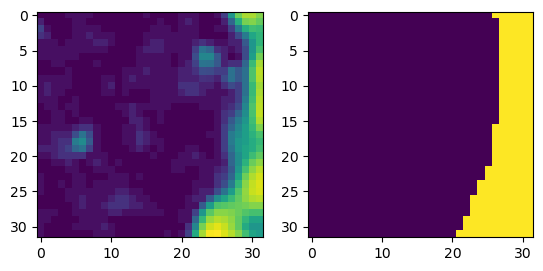

In [13]:
raw, output = next(train_iter)

sigma = 20

# lsds = local_shape_descriptor.get_local_shape_descriptors(
#                 segmentation=labels.squeeze(0),
#                 sigma=(sigma,)*2,
#                 voxel_size=(1,)*2)




# plt.imshow(np.squeeze(lsds[0,:,:]), cmap='jet')
# plt.imshow(np.squeeze(lsds[1,:,:]), cmap='jet', alpha=0.5)
# plt.title('sigma = ' + str(sigma))
# plt.show()


plt.subplot(1,2,1)
plt.imshow(raw[0])
plt.subplot(1,2,2)
plt.imshow(output[0])


# creation of the model

In [69]:
#@title simplified unet
#modified from https://github.com/dlmbl/instance_segmentation/blob/main/unet.py

class ConvPass(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes, padding, activation):

        super(ConvPass, self).__init__()

        if activation is not None:
            activation = getattr(torch.nn, activation)

        layers = []

        for kernel_size in kernel_sizes:
            self.dims = len(kernel_size)
            if padding in ("VALID", "valid"):
                pad = 0
            elif padding in ("SAME", "same"):
                pad = tuple(np.array(kernel_size) // 2)
            else:
                raise RuntimeError("invalid string value for padding")
            layers.append(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=pad)
            )
            in_channels = out_channels

            if activation is not None:
                layers.append(activation())

        self.conv_pass = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_pass(x)


class Downsample(torch.nn.Module):
    def __init__(self, downsample_factor):

        super(Downsample, self).__init__()

        self.dims = len(downsample_factor)
        self.downsample_factor = downsample_factor

        self.down = torch.nn.MaxPool2d(downsample_factor, stride=downsample_factor)

    def forward(self, x):
        for d in range(1, self.dims + 1):
            if x.size()[-d] % self.downsample_factor[-d] != 0:
                raise RuntimeError(
                    "Can not downsample shape %s with factor %s, mismatch "
                    "in spatial dimension %d"
                    % (x.size(), self.downsample_factor, self.dims - d)
                )

        return self.down(x)


class Upsample(torch.nn.Module):
    def __init__(
        self,
        scale_factor,
        mode="nearest",
        in_channels=None,
        out_channels=None,
        crop_factor=None,
        padding="VALID",
        next_conv_kernel_sizes=None,
    ):

        super(Upsample, self).__init__()

        assert (crop_factor is None) == (
            next_conv_kernel_sizes is None
        ), "crop_factor and next_conv_kernel_sizes have to be given together"

        self.crop_factor = crop_factor
        self.next_conv_kernel_sizes = next_conv_kernel_sizes
        self.padding = padding

        self.dims = len(scale_factor)

        if mode == "transposed_conv":
            self.up = torch.nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size=scale_factor, stride=scale_factor
            )
        else:
            self.up = torch.nn.Upsample(scale_factor=tuple(scale_factor), mode=mode)

    def crop_to_factor(self, x, factor, kernel_sizes):
        """Crop feature maps to ensure translation equivariance with stride of
        upsampling factor. This should be done right after upsampling, before
        application of the convolutions with the given kernel sizes.
        The crop could be done after the convolutions, but it is more efficient
        to do that before (feature maps will be smaller).
        """

        shape = x.size()
        spatial_shape = shape[-self.dims :]

        # the crop that will already be done due to the convolutions
        convolution_crop = tuple(
            sum(ks[d] - 1 for ks in kernel_sizes) for d in range(self.dims)
        )

        # we need (spatial_shape - convolution_crop) to be a multiple of
        # factor, i.e.:
        #
        # (s - c) = n*k
        #
        # we want to find the largest n for which s' = n*k + c <= s
        #
        # n = floor((s - c)/k)
        #
        # this gives us the target shape s'
        #
        # s' = n*k + c

        ns = (
            int(math.floor(float(s - c) / f))
            for s, c, f in zip(spatial_shape, convolution_crop, factor)
        )
        target_spatial_shape = tuple(
            n * f + c for n, c, f in zip(ns, convolution_crop, factor)
        )

        if target_spatial_shape != spatial_shape:

            assert all(
                ((t > c) for t, c in zip(target_spatial_shape, convolution_crop))
            ), (
                "Feature map with shape %s is too small to ensure "
                "translation equivariance with factor %s and following "
                "convolutions %s" % (shape, factor, kernel_sizes)
            )

            return self.crop(x, target_spatial_shape)

        return x

    def crop(self, x, shape):
        """Center-crop x to match spatial dimensions given by shape."""

        x_target_size = x.size()[: -self.dims] + shape

        offset = tuple((a - b) // 2 for a, b in zip(x.size(), x_target_size))

        slices = tuple(slice(o, o + s) for o, s in zip(offset, x_target_size))

        return x[slices]

    def forward(self, f_left, g_out):

        g_up = self.up(g_out)

        # if self.next_conv_kernel_sizes is not None and self.padding in ("VALID", "valid"):
        #    g_cropped = self.crop_to_factor(
        #        g_up,
        #        self.crop_factor,
        #        self.next_conv_kernel_sizes)
        # else:
        g_cropped = g_up

        f_cropped = self.crop(f_left, g_cropped.size()[-self.dims :])

        return torch.cat([f_cropped, g_cropped], dim=1)


class UNet(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        num_fmaps,
        fmap_inc_factors,
        downsample_factors,
        kernel_size_down=None,
        kernel_size_up=None,
        activation="ReLU",
        padding="VALID",
        num_fmaps_out=None,
        constant_upsample=False,
    ):
        """Create a U-Net::
            f_in --> f_left --------------------------->> f_right--> f_out
                        |                                   ^
                        v                                   |
                     g_in --> g_left ------->> g_right --> g_out
                                 |               ^
                                 v               |
                                       ...
        where each ``-->`` is a convolution pass, each `-->>` a crop, and down
        and up arrows are max-pooling and transposed convolutions,
        respectively.
        The U-Net expects 2D tensors shaped like::
            ``(batch=1, channels, height, width)``.
        This U-Net performs only "valid" convolutions, i.e., sizes of the
        feature maps decrease after each convolution.
        Args:
            in_channels:
                The number of input channels.
            num_fmaps:
                The number of feature maps in the first layer. This is also the
                number of output feature maps. Stored in the ``channels``
                dimension.
            fmap_inc_factors:
                By how much to multiply the number of feature maps between
                layers. If layer 0 has ``k`` feature maps, layer ``l`` will
                have ``k*fmap_inc_factor**l``.
            downsample_factors:
                List of tuples ``(y, x)`` to use to down- and up-sample the
                feature maps between layers.
            kernel_size_down (optional):
                List of lists of kernel sizes. The number of sizes in a list
                determines the number of convolutional layers in the
                corresponding level of the build on the left side. Kernel sizes
                can be given as tuples or integer. If not given, each
                convolutional pass will consist of two 3x3 convolutions.
            kernel_size_up (optional):
                List of lists of kernel sizes. The number of sizes in a list
                determines the number of convolutional layers in the
                corresponding level of the build on the right side. Within one
                of the lists going from left to right. Kernel sizes can be
                given as tuples or integer. If not given, each convolutional
                pass will consist of two 3x3 convolutions.
            activation:
                Which activation to use after a convolution. Accepts the name
                of any tensorflow activation function (e.g., ``ReLU`` for
                ``torch.nn.ReLU``).
            fov (optional):
                Initial field of view
            constant_upsample (optional):
                If set to true, perform a constant upsampling instead of a
                transposed convolution in the upsampling layers.
            padding (optional):
                How to pad convolutions. Either 'same' or 'valid' (default).
        """

        super(UNet, self).__init__()

        self.num_levels = len(downsample_factors) + 1
        self.in_channels = in_channels
        self.out_channels = num_fmaps_out if num_fmaps_out else num_fmaps
        self.constant_upsample = constant_upsample

        # default arguments
        if kernel_size_down is None:
            kernel_size_down = [[(3, 3), (3, 3)]] * self.num_levels
        if kernel_size_up is None:
            kernel_size_up = [[(3, 3), (3, 3)]] * (self.num_levels - 1)

        self.kernel_size_down = kernel_size_down
        self.kernel_size_up = kernel_size_up
        self.downsample_factors = downsample_factors

        # compute crop factors for translation equivariance
        crop_factors = []
        factor_product = None
        for factor in downsample_factors:
            if factor_product is None:
                factor_product = list(factor)
            else:
                factor_product = list(f * ff for f, ff in zip(factor, factor_product))
            crop_factors.append(factor_product)
        crop_factors = crop_factors[::-1]

        # modules

        # left convolutional passes
        self.l_conv = nn.ModuleList(
            [
                ConvPass(
                    in_channels
                    if level == 0
                    else num_fmaps * fmap_inc_factors ** (level - 1),
                    num_fmaps * fmap_inc_factors**level,
                    kernel_size_down[level],
                    padding,
                    activation=activation,
                )
                for level in range(self.num_levels)
            ]
        )
        self.dims = self.l_conv[0].dims

        # left downsample layers
        self.l_down = nn.ModuleList(
            [
                Downsample(downsample_factors[level])
                for level in range(self.num_levels - 1)
            ]
        )

        # right up/crop/concatenate layers
        self.r_up = nn.ModuleList(
            [
                Upsample(
                    downsample_factors[level],
                    mode="nearest" if constant_upsample else "transposed_conv",
                    in_channels=num_fmaps * fmap_inc_factors ** (level + 1),
                    out_channels=num_fmaps * fmap_inc_factors ** (level + 1),
                    crop_factor=crop_factors[level],
                    padding=padding,
                    next_conv_kernel_sizes=kernel_size_up[level],
                )
                for level in range(self.num_levels - 1)
            ]
        )

        # right convolutional passes
        self.r_conv = nn.ModuleList(
            [
                ConvPass(
                    num_fmaps * fmap_inc_factors**level
                    + num_fmaps * fmap_inc_factors ** (level + 1),
                    num_fmaps * fmap_inc_factors**level
                    if num_fmaps_out is None or level != 0
                    else num_fmaps_out,
                    kernel_size_up[level],
                    padding,
                    activation=activation,
                )
                for level in range(self.num_levels - 1)
            ]
        )

    def rec_fov(self, level, fov, sp):

        # index of level in layer arrays
        i = self.num_levels - level - 1

        # convolve
        for j in range(len(self.kernel_size_down[i])):
            fov += (np.array(self.kernel_size_down[i][j]) - 1) * sp

        # end of recursion
        if level != 0:
            # down
            fov += (np.array(self.downsample_factors[i]) - 1) * sp
            sp *= np.array(self.downsample_factors[i])

            # nested levels
            fov, sp = self.rec_fov(level - 1, fov, sp)

            # up
            sp //= np.array(self.downsample_factors[i])

            # convolve
            for j in range(len(self.kernel_size_up[i])):
                fov += (np.array(self.kernel_size_up[i][j]) - 1) * sp

        return fov, sp

    def get_fov(self):
        fov, sp = self.rec_fov(self.num_levels - 1, (1, 1), 1)
        return fov

    def rec_forward(self, level, f_in):

        # index of level in layer arrays
        i = self.num_levels - level - 1

        # convolve
        f_left = self.l_conv[i](f_in)

        # end of recursion
        if level == 0:
            fs_out = f_left
        else:
            # down
            g_in = self.l_down[i](f_left)
            # nested levels
            gs_out = self.rec_forward(level - 1, g_in)
            # up, concat, and crop
            fs_right = self.r_up[i](f_left, gs_out)

            # convolve
            fs_out = self.r_conv[i](fs_right)

        return fs_out

    def forward(self, x):

        y = self.rec_forward(self.num_levels - 1, x)

        return y

# input - output

In [ ]:
possible_inputs = {'raw': 1,
                   'lsds': 6,
                   'raw_lsds': 7}

possible_outputs = {'labels': 1,
                    'lsds': 6,
                    'boundaries': 1,
                    'boundaries_lsds': 7,
                    'affinities': 2,
                    'affinities_lsds': 8}


input_type = 'raw'
output_type = 'boundaries_lsds'




In [71]:
torch.manual_seed(42)

num_in_channels = possible_inputs[input_type]
num_out_channels = possible_outputs[output_type]

# create our network

d_factors = [[2,2],[2,2],[2,2]]

num_fmaps=12
fmap_inc_factor=5

unet = UNet(
    in_channels=num_in_channels,
    num_fmaps=num_fmaps,
    fmap_inc_factors=fmap_inc_factor,
    downsample_factors=d_factors,
    padding='same',
    constant_upsample=True)

model = torch.nn.Sequential(
    unet,
    torch.nn.Conv2d(in_channels=num_fmaps,out_channels=num_out_channels, kernel_size=1)
).to(device)

loss_fn = torch.nn.MSELoss().to(device)

### creating the lsd_model for the lsd input predictions

In [125]:
model_lsd = UNet(
    in_channels=1,
    num_fmaps=12,
    fmap_inc_factors=5,
    downsample_factors=[[2,2],[2,2],[2,2]],
    padding='same',
    constant_upsample=True)


model_lsd = torch.nn.Sequential(
    model_lsd,
    torch.nn.Conv2d(in_channels=12,out_channels=6, kernel_size=1)
).to(device)


model_lsd.load_state_dict(torch.load('/home/enrico.negri/github/lsd_testing/output_5000_4_512/raw-lsds.pth', weights_only=True))
model_lsd.eval()

Sequential(
  (0): UNet(
    (l_conv): ModuleList(
      (0): ConvPass(
        (conv_pass): Sequential(
          (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (1): ConvPass(
        (conv_pass): Sequential(
          (0): Conv2d(12, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (2): ConvPass(
        (conv_pass): Sequential(
          (0): Conv2d(60, 300, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(300, 300, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (3): ConvPass(
        (conv_pass): Sequential(
          (0): Conv2d(300, 1500, kernel_size=(3, 3), stride

testing lsds prediction as input

In [122]:
train_dataset = CellDataset(
    image_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + input_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + segmentation_dataset + '.tif',
    crop_size=1024,
    input_type='lsds', output_type='boundaries',
    split='train',
    model=model_lsd)


train_iter = iter(train_dataset)

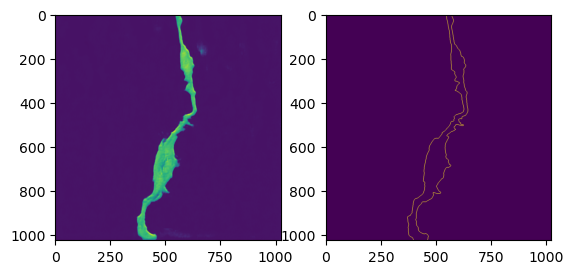

In [123]:
lsds, boundaries = next(train_iter)
plt.subplot(1,2,1)
plt.imshow(lsds[0])
plt.subplot(1,2,2)
plt.imshow(boundaries[0])

# set up of the model

## important settings

In [23]:

crop_size = 256
training_steps = 200

# set optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# set activation
activation = torch.nn.Sigmoid()

### create datasets


train_dataset = CellDataset(
    image_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + input_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi_projection/training/*' + segmentation_dataset + '.tif',
    crop_size=crop_size,
    split='train',
    input_type=input_type, output_type=output_type)

val_dataset = CellDataset(
    image_dir='/group/jug/Enrico/TISSUE_roi_projection/validation/*' + input_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi_projection/validation/*' + segmentation_dataset + '.tif',
    crop_size=crop_size,
    split='val',
    input_type=input_type, output_type=output_type)


batch_size = 4


# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset)

In [11]:
input, output = next(iter(train_dataset))
print(input.shape)
print(output.shape)

(1, 128, 128)
(7, 128, 128)


# training code

In [24]:
# training step

def model_step(model, loss_fn, optimizer, feature, gt_target, activation, train_step=True):
    
    # zero gradients if training
    if train_step:
        optimizer.zero_grad()
        
    # forward
    target_logits = model(feature)

    loss_value = loss_fn(target_logits, gt_target)
    
    # backward if training mode
    if train_step:
        loss_value.backward()
        optimizer.step()
        
    target_output = activation(target_logits)
   
    outputs = {
        'pred_target': target_output,
        'target_logits': target_logits,
    }
    
    return loss_value, outputs

In [25]:
# training loop

# set flags
model.train() 
loss_fn.train()
step = 0

np.random.seed(42)

metrics = pd.DataFrame(columns=['step', 'loss'])

with tqdm(total=training_steps) as pbar:
    while step < training_steps:
        # reset data loader to get random augmentations
        
        tmp_loader = iter(train_loader)

        for feature, gt_target in tmp_loader:
            feature = feature.to(device)
            gt_target = gt_target.to(device)
                                          
            loss_value, pred = model_step(model, loss_fn, optimizer, feature, gt_target, activation)
            step += 1
            pbar.update(1)
            
            if step % 100 == 0:
                model.eval()
                tmp_val_loader = iter(val_loader)
                acc_loss = []
                for feature, gt_target in tmp_val_loader:
                    feature = feature.to(device)
                    gt_target = gt_target.to(device)

                    loss_value, _ = model_step(model, loss_fn, optimizer, feature, gt_target, activation, train_step=False)
                    acc_loss.append(loss_value.cpu().detach().numpy())
                model.train()
                
                # adding the metrics to the dataframe
                new_row = {'step': step, 'loss': np.mean(acc_loss)}
                metrics.loc[len(metrics)] = new_row
                metrics = metrics.reset_index(drop=True)
                print(np.mean(acc_loss))

  0%|          | 0/200 [00:00<?, ?it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  1%|          | 2/200 [00:02<03:54,  1.19s/it]

256
2

256
2

128
2

128
2

64
2

64
2



  2%|▏         | 3/200 [00:03<02:43,  1.20it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  2%|▏         | 4/200 [00:03<02:26,  1.33it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  2%|▎         | 5/200 [00:04<02:06,  1.55it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  3%|▎         | 6/200 [00:04<01:50,  1.76it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  4%|▎         | 7/200 [00:05<01:49,  1.77it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  4%|▍         | 8/200 [00:05<01:44,  1.84it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  4%|▍         | 9/200 [00:06<01:49,  1.75it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  5%|▌         | 10/200 [00:06<01:43,  1.84it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  6%|▌         | 11/200 [00:07<01:30,  2.10it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  6%|▌         | 12/200 [00:07<01:32,  2.02it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  6%|▋         | 13/200 [00:07<01:19,  2.36it/s]

256
2

256
2

128
2

128
2

64
2

64
2



  6%|▋         | 13/200 [00:08<01:56,  1.60it/s]


KeyboardInterrupt: 

(0.0, 0.09896962344646454)

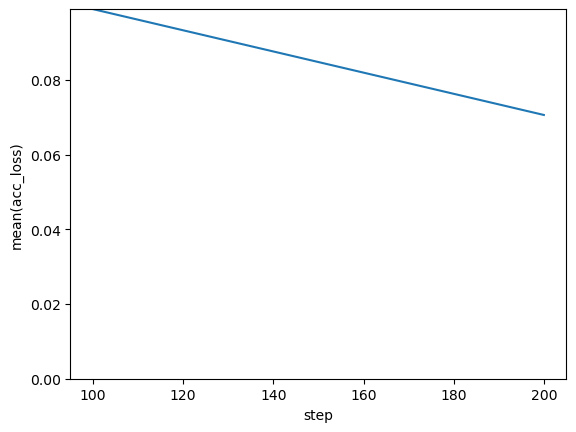

In [ ]:
if os.path.exists('output') == False:
    os.makedirs('output')

metrics.to_csv('output/' + input_type + '->' + output_type + '.csv', index=False)


plt.plot(metrics['step'], metrics['loss'])
plt.xlabel('step')
plt.ylabel('mean(acc_loss)')
plt.ylim([0, np.max(metrics['loss'])])

In [15]:
model.eval()

activation = torch.nn.Sigmoid()


IndexError: index 6 is out of bounds for axis 0 with size 6

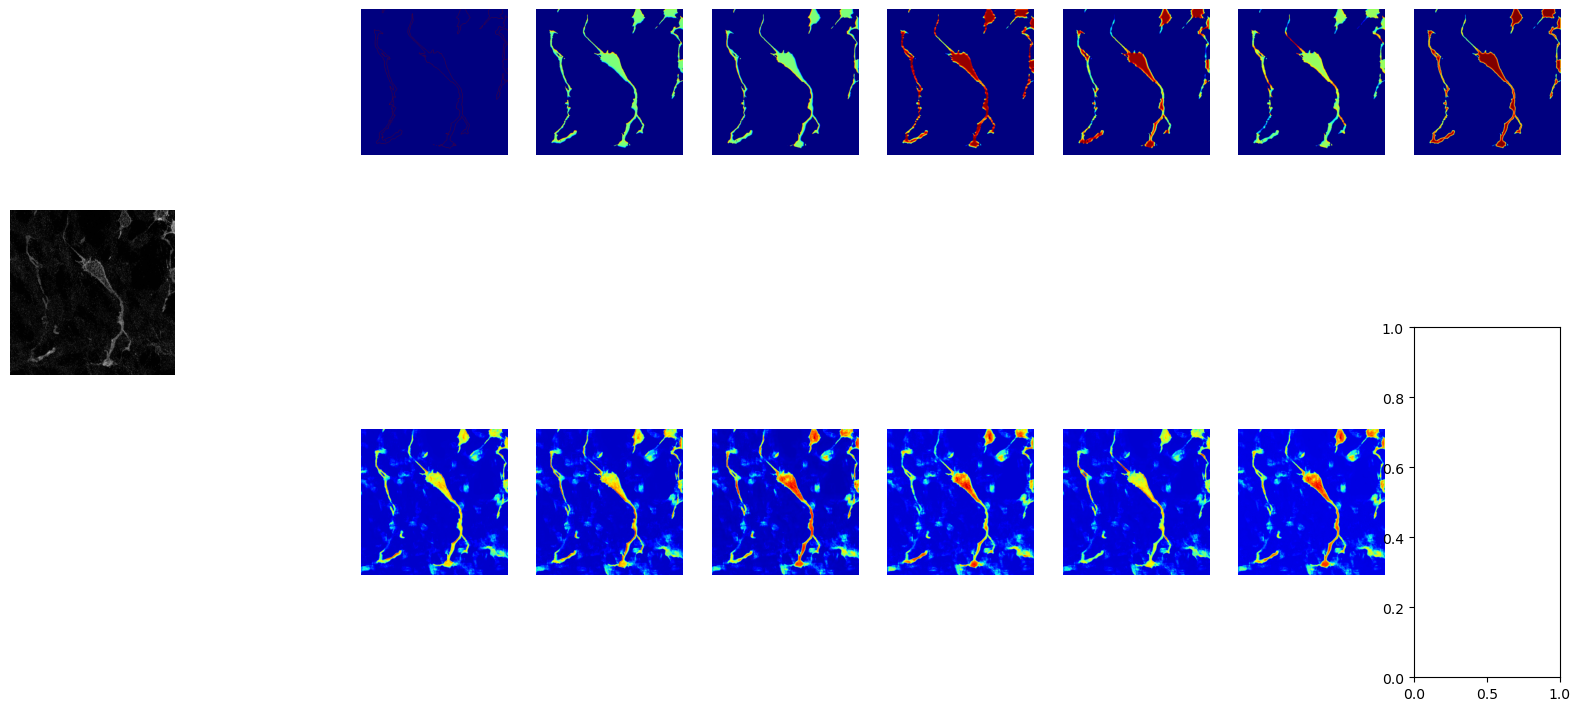

In [84]:
# visualize a few predictions

val_dataset = CellDataset(
    image_dir='/group/jug/Enrico/TISSUE_roi_projection/validation/*' + input_dataset + '.tif',
    mask_dir='/group/jug/Enrico/TISSUE_roi_projection/validation/*' + segmentation_dataset + '.tif',
    crop_size=1024, split='val',
    input_type=input_type, output_type=output_type)

val_loader = DataLoader(val_dataset)

for idx, (input, output) in enumerate(val_loader):
    image = input.to(device)

    target_logits = model(image)
    pred_target = activation(target_logits)
        
    image = np.squeeze(image.cpu())
    
    pred_target = np.squeeze(pred_target.cpu().detach().numpy())
    
    output_dim = output.shape[1]

    plt.figure(figsize=(20, 10))
    plt.subplot(1,1+output_dim,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')


    for i in range(output_dim):
        if output_type == 'boundaries':
            cmap = 'inferno'
        else:
            cmap = 'jet'
        plt.subplot(2,2+output_dim,i+3)
        plt.imshow(output[0,i], cmap=cmap)
        plt.axis('off')

        plt.subplot(2,2+output_dim,i+5+output_dim)
        plt.imshow(np.squeeze(pred_target[i]), cmap=cmap)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('output/' + input_type + '->' + output_type + '_' + str(idx) + '.png', dpi=100)
    plt.show()

    if idx > 0:
        break